In [38]:
import pandas as pd
import anndata as ad
import scanpy as sc
import glob
import numpy as np
import QCPipe
import skmisc
import seaborn as sns
import matplotlib.pyplot as plt
import dropkick as dk #Contains dropkick functions

In [ ]:
# concatenate datasets 1,3,5,6

# adata_1 = sc.read_csv('data/4903-YW/4903-YX-1_S01.csv')
# adata_3 = sc.read_csv('data/4903-YW/4903-YX-3_S01.csv')
# adata_5 = sc.read_csv('data/4903-YW/4903-YX-5_S01.csv')
# adata_6 = sc.read_csv('data/4903-YW/4903-YX-6_S01.csv')

# batch_name = ['1', '3', '5', '6']

# adata = adata_1.concatenate(adata_3, adata_5, adata_6, join='outer',fill_value=0,batch_categories=batch_name)

# adata.write_h5ad('data/4903-YW/4903_concat.h5ad',compression='gzip')
# adata = sc.read_h5ad('data/4903-YW/4903_concat.h5ad')

In [39]:
adata_1 = sc.read_csv('data/4903-YW/4903-YX-1_S01.csv')

In [40]:
adata_3 = sc.read_csv('data/4903-YW/4903-YX-3_S01.csv')
adata_5 = sc.read_csv('data/4903-YW/4903-YX-5_S01.csv')
adata_6 = sc.read_csv('data/4903-YW/4903-YX-6_S01.csv')

In [41]:
batch_name = ['1', '3', '5', '6']

In [42]:
adata = adata_1.concatenate(adata_3, adata_5, adata_6, join='outer',fill_value=0,batch_categories=batch_name)

/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [43]:
adata

AnnData object with n_obs × n_vars = 100800 × 5000
    obs: 'batch'

In [44]:
adata.write_h5ad('data/4903-YW/4903_concat.h5ad',compression='gzip')

In [47]:
adata = sc.read_h5ad('data/4903-YW/4903_concat.h5ad')

In [45]:
sc.pp.normalize_total(adata)
adata.X = np.arcsinh(adata.X).copy()
sc.pp.scale(adata)
sc.pp.pca(adata,random_state=0)
neighborhood_k = np.sqrt(adata.n_obs).astype(int) 
sc.pp.neighbors(adata,n_neighbors=neighborhood_k,use_rep='X_pca',random_state=0)
sc.tl.umap(adata,min_dist=0.25,random_state=0)
sc.tl.leiden(adata,resolution=2,random_state=0)

/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


/home/jonathan/apps/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


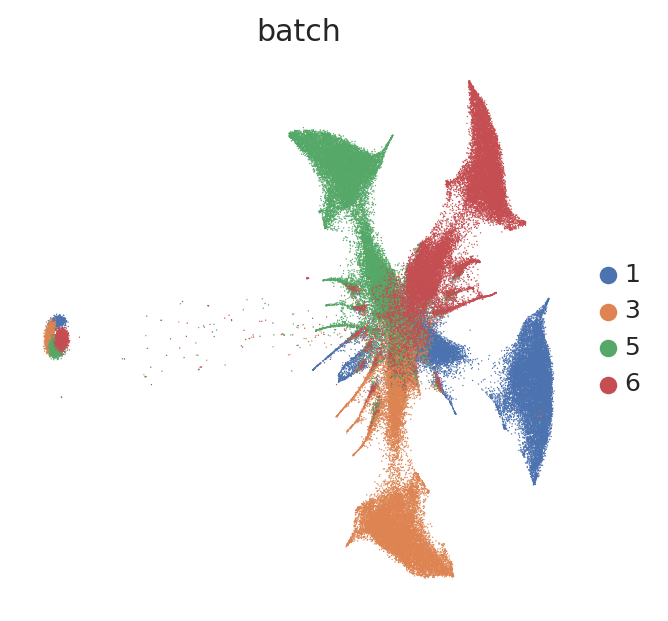

In [46]:
sc.pl.umap(adata,color=['batch'],legend_fontoutline=True,legend_fontsize=10,cmap='viridis',ncols=3,save='batch.png',wspace=0.3,frameon=False)